In [ ]:
from ibapi.contract import Contract
from ibapi.client import EClient
from ibapi.wrapper import EWrapper
import psycopg2
import threading
from time import sleep
import pandas as pd

df = pd.read_parquet("US100.parquet")
code_list = list(df.columns)
code_list = [i for i in code_list if i != "US100"]
len(code_list)
code_list = code_list + ['QQQ']
# try:
#     app.disconnect()
# except:
#     pass
class IBapi(EWrapper, EClient):
    def __init__(self):
        EClient.__init__(self, self)
        self.df = []
        self.minute = -1
        self.count = 0
        self.req_id_to_contract = {}

    def realtimeBar(self, reqId, time, open_, high, low, close, volume, wap, count):
        timestamp_utc = pd.to_datetime(time, unit='s', utc=True)
        tz = 'America/New_York'
        da = timestamp_utc.tz_convert(tz).strftime("%Y-%m-%d %H:%M:%S")
        # print(close, da, reqId)
        code = code_list[reqId-1]
        if da[-2:] == '00':
            self.df.append([da, code, close])
            
def run_loop():
    app.run()

app = IBapi()
app.connect('127.0.0.1', 7496, 1232)
api_thread = threading.Thread(target=run_loop, daemon=True)
api_thread.start()
reqID = 1
for symbol in code_list:
    contract = Contract()
    contract.symbol = symbol
    contract.secType = 'STK'
    contract.exchange = 'SMART'
    contract.currency = 'USD'
    app.reqRealTimeBars(reqId=reqID, contract=contract, barSize=5, whatToShow="MIDPOINT", useRTH=1, realTimeBarsOptions=[])
    reqID += 1

ERROR -1 2104 Market data farm connection is OK:hfarm
ERROR -1 2104 Market data farm connection is OK:eufarmnj
ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR -1 2104 Market data farm connection is OK:usfuture
ERROR -1 2104 Market data farm connection is OK:usbond
ERROR -1 2104 Market data farm connection is OK:jfarm
ERROR -1 2104 Market data farm connection is OK:usfarm.nj
ERROR -1 2104 Market data farm connection is OK:eufarm
ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR -1 2106 HMDS data farm connection is OK:euhmds
ERROR -1 2106 HMDS data farm connection is OK:fundfarm
ERROR -1 2106 HMDS data farm connection is OK:ushmds
ERROR -1 2158 Sec-def data farm connection is OK:secdefnj


ERROR 2 200 The contract description specified for ABNB is ambiguous.
ERROR 29 200 The contract description specified for CSCO is ambiguous.
ERROR 40 200 The contract description specified for FANG is ambiguous.
ERROR 65 200 The contract description specified for META is ambiguous.
ERROR -1 2104 Market data farm connection is OK:usopt
ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.hfarm
ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.hfarm
ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.eufarmnj
ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.eufarmnj
ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.usfuture
ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.jfarm
ERROR -1 2108 Market data farm connection is inactive but should be available 

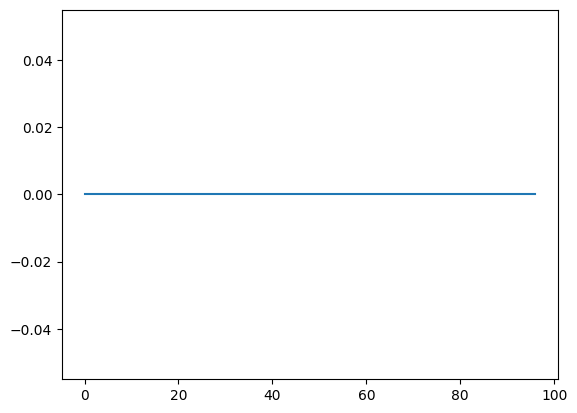

2024-08-27 16:03:00


In [ ]:
import pandas as pd
from datetime import datetime
import threading
import time
from IPython.display import display, clear_output
import psycopg2
# Assuming app and backtest_code are already defined
class ContinuousProcessor:
    def __init__(self):
        self.index_da = None
        self.lock = threading.Lock()
        self.running = True
        
        self.conn = self.get_db_connection()
        self.cursor = self.conn.cursor()
    def get_db_connection(self):
        DB_HOST = 'localhost'
        DB_NAME = 'us'
        DB_USER = 'postgres'
        DB_PASS = 'buddyrich134'
        conn = psycopg2.connect(host=DB_HOST, dbname=DB_NAME, user=DB_USER, password=DB_PASS)
        return conn
    def backtest_code(self, pivoted, code, rolling=10, benchmark_index='QQQ'):
        try:
            pivoted.ffill()
            ret = pivoted.pct_change(fill_method=None)
            ret['stock_price'] = pivoted[code]
            ret['index_price'] = pivoted[benchmark_index]
            ret['ret_diff'] = ret[code] - ret[benchmark_index]
            # type 2
            ret['ret_diff_std'] = ret['ret_diff'].rolling(rolling).std()
            ret['ret_diff_mean'] = ret['ret_diff'].rolling(rolling).mean()
            ret['stdize_ret_diff'] = abs((ret['ret_diff'] - ret['ret_diff_mean'])*ret['ret_diff_std'])*10000

            # # check direction
            ret['lag10'] = ret['stock_price'].shift(5)
            ret['change_stock'] = (ret['stock_price'] - ret['lag10'])/ret['lag10']
            ret['direction'] = ret.apply(lambda x: -1 if x['stock_price'] - x['lag10'] > 0 else 1, axis=1)
            
            # # check if the direction are the same, if not, tned to not being a mean reversion
            ret['lag10_twii'] = ret['index_price'].shift(5)
            ret['change_twii'] = (ret['index_price'] - ret['lag10_twii'])/ret['lag10_twii']
            ret['filter_1'] = ret.apply(lambda x: 1 if abs(x['change_stock'] - x['change_twii']) < abs(x['change_stock']) else 0, axis=1)
            ret['filter_2'] = ret.apply(lambda x: 1 if abs(x['change_stock']) < abs(x['change_twii']) else 1, axis=1)
            last = ret.iloc[-1, :]
            da = last.index[-1]
            if last['stdize_ret_diff'] >= 2:
                RED_BACKGROUND = '\033[101m'
                GREEN_BACKGROUND = '\033[102m'
                RESET = '\033[0m'
                color = RED_BACKGROUND if last['direction'] == -1 else GREEN_BACKGROUND
                print(f"{color}{code}, direction:, {last['direction']}, f1: {last['filter_1']}, f2: {last['filter_2']}{RESET}")
                if last['filter_1'] == 1 and last['filter_2'] == 1:
                    self.cursor.execute("INSERT INTO public.block_code3_deatil (da, code, direction, strategy) VALUES (%s, %s, %s, %s)", (da, code, last['direction'], 'intraday_mr'))
                    self.conn.commit()
        except Exception as e:
            print(e, code)
    def continuous_loop(self):
        while self.running:
            df = pd.DataFrame(app.df[-2000:], columns=['da', 'code', 'cl'])
            df = df.pivot(values='cl', columns='code', index='da').sort_index(ascending=True)
            index = df.index[-1]
            if len(df) >= 15 and self.index_da != index:
                self.index_da = index
                clear_output(wait=True)
                display(f'Running analysis for index: {self.index_da}')
                for code in df.columns:
                    if code == "QQQ":
                        continue
                    self.backtest_code(df[['QQQ', code]], code)
                ####
                time.sleep(30)
                pd.DataFrame(app.df[-2000:], columns=['da', 'code', 'cl']).to_parquet("US100.parquet")
                
                self.cursor.execute("SELECT da from public.stock_price order by da desc limit 1;")
                self.conn.commit()
                
                try:
                    da = self.cursor.fetchone()[0]
                    print(da)
                    insert_df = pd.DataFrame(app.df[-500:], columns=['da', 'code', 'cl'])
                    insert_df = insert_df[pd.to_datetime(insert_df['da']) > da]
                except:
                    insert_df = pd.DataFrame(app.df[:], columns=['da', 'code', 'cl'])
                self.cursor.executemany("INSERT INTO public.stock_price (da, code, cl) VALUES (%s, %s, %s);", insert_df.values.tolist())
                self.conn.commit()

                ####

    def stop(self):
        self.running = False

processor = ContinuousProcessor()
loop_thread = threading.Thread(target=processor.continuous_loop, daemon=True)
loop_thread.start()